## Oceanbolt Python SDK Lesson 2: Proportion of Unique Vessel Routes by Segment

This is the second lesson in our learning series for the Oceanbolt Python SDK.

In this example, we are investigating the proportion of vessels taking unique routes by segment in 2020, e.g. answering the question: "What percentage of the VLOC fleet served unique trade lanes only in 2020?". We define unique routes, or trade lanes as we refer to them at Oceanbolt, as the same pair of load port and discharge ports.

You can find an article with more results from other segments: https://www.oceanbolt.com/blog/oceanbolt_python_sdk_unique_trade_lanes/

In [1]:
# Import the relevant libraries
# In order to get a timeseries of weekly export volumes, we use the TradeFlows client (https://python-sdk.oceanbolt.com/tradeflows_v3/tradeflows.html)

from oceanbolt.sdk.client import APIClient
from oceanbolt.sdk.data.trade_flows import TradeFlows
from oceanbolt.sdk.data.entities import Segments
from datetime import date
import pandas as pd

In [2]:
# Create the base API client using your token. Tokens can be created in the Oceanbolt App (app.oceanbolt.com)
base_client = APIClient("<token>")

In [3]:
# We will be investigating all subsegments (ex. shortsea). The code example will only include the code for the VLOC fleet.

df = Segments(base_client).get()
df['sub_segment_key'] # Let's list the sub-segment keys to get the input for our request body.

0            shortsea
1     small_handysize
2     large_handysize
3            handymax
4            supramax
5            ultramax
6             panamax
7           kamsarmax
8        post_panamax
9            babycape
10           capesize
11     large_capesize
12               vloc
Name: sub_segment_key, dtype: string

In [4]:
# Connect to the relevant Oceanbolt data endpoints using the base client object, ie: TradeFlows
trade_flow_client = TradeFlows(base_client)

In [5]:
# We apply filters to our query to get a list of all 2020 voyages for the vloc fleet.
# A complete list of available filters can be found at https://python-sdk.oceanbolt.com/tradeflows_v3/tradeflows.html#arguments

df = trade_flow_client.get(
    max_results = 20000, # Remember to include the max_results parameter to ensure that all results are capture. The default max_results is set to 10.
    sub_segment=['vloc'],
    start_date=date(2020, 1, 1), 
    end_date=date(2020, 12, 31),
)

In [6]:
# We generate our trade lanes (or routes) as a new column. 
df['trade_lane'] = df['load_port_name'] + ' --> ' + df['discharge_port_name']

# Then sort away incomplete pairs.
df = df[(df['load_port_id'].notnull()) & (df['discharge_port_id'].notnull())]

In [7]:
# We count the number of unique trade lanes and total trade lanes by imo
unique_tl_count = df.groupby('imo')['trade_lane'].nunique()
all_tl_count = df.groupby('imo')['trade_lane'].count()

# And then create data frames to capture the values.
all_tl_count_df = pd.DataFrame(all_tl_count).rename(columns={'trade_lane': 'all trade lanes count'})
unique_tl_count_df = pd.DataFrame(unique_tl_count).rename(columns={'trade_lane': 'unique trade lanes count'})

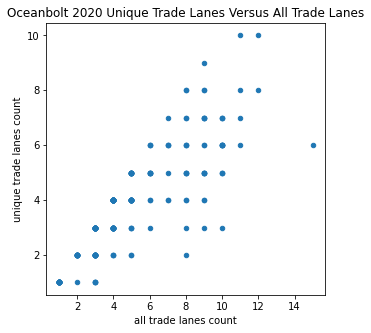

In [8]:
# Let us plot the vessels in a scatter plot.

tl_counts = pd.concat([all_tl_count_df, unique_tl_count_df], axis=1)
tl_counts.plot(x='all trade lanes count', y='unique trade lanes count', title='Oceanbolt 2020 Unique Trade Lanes Versus All Trade Lanes', kind='scatter', figsize=(5,5));

So certainly for the VLOC fleet, there are a large proportion of the vessels that have only taken unique routes, but let us quantify this metric: 

In [14]:
tl_counts['proportion unique'] = tl_counts['unique trade lanes count'] / tl_counts['all trade lanes count']
unique_only = tl_counts['proportion unique'][tl_counts['proportion unique'] == 1.0].count()
fraction_unique_only = unique_only / tl_counts['proportion unique'].count()
fraction_unique_only.round(2)

0.45

We see that 45% of the VLOC fleet took only unique trade lanes (routes) in 2020. Arguably, this metric is rather crude and can be improved in several ways. Importantly, it does not take into account the total number of voyages by vessel, meaning that a new built vessel from Sep 2020 with only one voyage in 2020 will be counted as all unique. 

Cleaning this data further is outside of the scope of this lesson and we will leave it to the users to do this excercise.

You might be wondering how this stacks up against the other sub-segments. Check out our blog post to find out: https://www.oceanbolt.com/blog/oceanbolt_python_sdk_unique_trade_lanes/

In [10]:
# If we want to know which vessels take unique trade lanes only  
tl_counts['proportion unique'].sort_values().head(1)

imo
9582245    0.25
Name: proportion unique, dtype: float64

The vessel with imo 9582245, HYUNDAI DANGJIN, has a the lowest ratios unique trade lanes to total trade lanes. From this metric, we would expect that the vessel has been employed on fixed route. Surely, by investigating this vessel in the Oceanbolt Data Platform (https://app.oceanbolt.com/vessel-details?imo=9582245), we see that it has only been engaged in supplying Australian iron ore to Hyundai Steel's Pyeongtaek plant.      